In [1]:
import torch

num_gpus = torch.cuda.device_count()
num_cpus = torch.get_num_threads()

print(f"Number of available CPU cores: {num_cpus}")
print(f"Number of available GPUs: {num_gpus}")

Number of available CPU cores: 1
Number of available GPUs: 1


In [2]:
%%capture
!git clone https://github.com/aliabbasi2000/PIDNet.git
%cd /content/PIDNet/

In [3]:
%%capture
!wget https://zenodo.org/record/5706578/files/Train.zip
!wget https://zenodo.org/record/5706578/files/Val.zip
!unzip Train.zip -d ./LoveDA
!unzip Val.zip -d ./LoveDA

In [4]:
%%capture
!wget --content-disposition "https://drive.usercontent.google.com/u/0/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download"
!mv PIDNet_S_ImageNet.pth.tar /content/PIDNet/pretrained_models/imagenet

In [5]:
import os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from albumentations import Compose, Normalize, Resize
from albumentations.pytorch import ToTensorV2
import cv2

class LoveDADataset(Dataset):
    def __init__(self, root, split='train', region='urban', transform=None):
        self.root = root
        self.split = split
        self.region = region
        self.image_dir = os.path.join(root, split, region, 'images_png')
        self.mask_dir = os.path.join(root, split, region, 'masks_png')
        self.images = sorted(os.listdir(self.image_dir))
        self.masks = sorted(os.listdir(self.mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      image_path = os.path.join(self.image_dir, self.images[idx])
      mask_path = os.path.join(self.mask_dir, self.masks[idx])

      # Load the image and mask
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

      # Convert mask to tensor and shift labels
      mask = np.array(mask, dtype=np.int64) - 1  # Shift labels to range [0, 6]
      mask = np.clip(mask, 0, num_classes - 1)  # Ensure no negative values

      # Apply transformations if specified
      if self.transform:
          augmented = self.transform(image=image, mask=mask)
          image = augmented["image"]
          mask = augmented["mask"]

      # Convert to PyTorch tensors
      image = image.clone().detach().float()  # HWC to CHW
      mask = mask.clone().detach().long()

      return image, mask


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
from torch.utils.data import DataLoader
from albumentations import Compose, HorizontalFlip, RandomRotate90, RandomCrop, VerticalFlip, Normalize, OneOf, NoOp, GaussianBlur, RandomBrightnessContrast, MultiplicativeNoise
from torchvision.transforms import ToTensor
from torchvision import transforms

# Define transforms for training phase
from albumentations.pytorch import ToTensorV2

train_transform = Compose([
    Resize(512, 512),  # Resize both image and mask
    # Augmentation
    OneOf([
      HorizontalFlip(p=0.5),
      VerticalFlip(p=0.5),
      RandomRotate90(p=0.5),
      GaussianBlur(blur_limit=(3, 7), p=0.5),
      RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Adjust brightness and contrast
      MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.5),

      NoOp()  # do no augmentation some times
    ], p=0.75),  # The entire block is applied with 75% probability

    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], always_apply=True),  # Normalize
    ToTensorV2()  # Convert to PyTorch tensors
])

# Define transforms for the evaluation phase

eval_transform = Compose([
    Resize(512, 512),  # Resize to match the input size of the model
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], always_apply=True),  # Normalize with ImageNet stats
    ToTensorV2()  # Convert to PyTorch tensors
])

# Define dataset paths
data_root = '/content/PIDNet/LoveDA'


# Load datasets
train_dataset = LoveDADataset(root=data_root, split='Train', region='Urban', transform=train_transform)
val_dataset = LoveDADataset(root=data_root, split='Val', region='Rural', transform=eval_transform)


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)



In [ ]:
import torch
from collections import Counter
import numpy as np
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2

# Assuming you already have your dataset and transforms like in your code

def count_classes_in_dataset(dataloader):
    class_counter = Counter()  # This will store the count of each class

    # Iterate over the DataLoader
    for data in dataloader:
        # data[1] is the mask, assuming it is the second element in your dataset
        masks = data[1].cpu().numpy()  # Convert the mask tensor to numpy for easy processing

        # If your mask has more than one channel, you may need to loop over each channel
        for mask in masks:
            # Flatten the mask to count the occurrences of each class (pixel-wise)
            unique_classes = np.unique(mask)
            class_counter.update(unique_classes)

    return class_counter


# Assuming your train_loader and val_loader are defined as in your code
train_class_distribution = count_classes_in_dataset(train_loader)
val_class_distribution = count_classes_in_dataset(val_loader)

# Print out the distribution of classes in training and validation sets
print(f"Training set class distribution: {train_class_distribution}")
print(f"Validation set class distribution: {val_class_distribution}")

# You can calculate the class weights based on the frequency of each class
total_pixels_train = sum(train_class_distribution.values())
total_pixels_val = sum(val_class_distribution.values())

train_class_weights = {cls: total_pixels_train / freq for cls, freq in train_class_distribution.items()}
val_class_weights = {cls: total_pixels_val / freq for cls, freq in val_class_distribution.items()}

print(f"Class weights for training set: {train_class_weights}")
print(f"Class weights for validation set: {val_class_weights}")


Training set class distribution: Counter({0: 1147, 1: 1094, 2: 1015, 5: 826, 4: 586, 3: 406, 6: 186})
Validation set class distribution: Counter({0: 985, 3: 847, 6: 748, 2: 678, 5: 602, 1: 520, 4: 383})
Class weights for training set: {0: 4.585876198779425, 1: 4.8080438756855575, 2: 5.182266009852217, 4: 8.976109215017065, 5: 6.368038740920097, 3: 12.955665024630543, 6: 28.27956989247312}
Class weights for validation set: {0: 4.835532994923858, 1: 9.159615384615385, 2: 7.025073746312684, 3: 5.623376623376624, 4: 12.43603133159269, 6: 6.367647058823529, 5: 7.911960132890365}


In [7]:
import torch
import torch.nn as nn

# Define class weights (you have already calculated these)
train_class_weights = {
    0: 4.585876198779425,
    1: 4.8080438756855575,
    2: 5.182266009852217,
    3: 12.955665024630543,
    4: 8.976109215017065,
    5: 6.368038740920097,
    6: 28.27956989247312
}

val_class_weights = {
    0: 4.835532994923858,
    1: 9.159615384615385,
    2: 7.025073746312684,
    3: 5.623376623376624,
    4: 12.43603133159269,
    5: 7.911960132890365,
    6: 6.367647058823529
}

# Convert these into tensors for use in loss functions
train_weights_tensor = torch.tensor([train_class_weights[i] for i in range(7)], dtype=torch.float32)
val_weights_tensor = torch.tensor([val_class_weights[i] for i in range(7)], dtype=torch.float32)

# Print to confirm
print(train_weights_tensor)


tensor([ 4.5859,  4.8080,  5.1823, 12.9557,  8.9761,  6.3680, 28.2796])


In [8]:
import torch
from models.pidnet import get_seg_model
import yaml

## get_pred ------------------------------------
#model = get_pred_model('pidnet_s', num_classes=7)

## get_seg ------------------------------------
# Convert the dictionary to a DotDict
class DotDict(dict):
    """A dictionary that supports attribute-style access."""
    def __getattr__(self, name):
        value = self.get(name)
        if isinstance(value, dict):
            return DotDict(value)
        return value

    def __setattr__(self, name, value):
        self[name] = value

# Load the YAML configuration
with open('/content/PIDNet/configs/loveda/pidnet_small_loveda.yaml', 'r') as f:
    cfg_dict = yaml.safe_load(f)

# Convert to DotDict for attribute-style access
cfg = DotDict(cfg_dict)

imgnet = 'imagenet' in cfg.MODEL.PRETRAINED

model = get_seg_model(cfg, imgnet_pretrained=imgnet)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)




/content/PIDNet/models/pidnet.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']


In [12]:
import torch.nn as nn
train_weights_tensor = train_weights_tensor.to(device)
val_weights_tensor = val_weights_tensor.to(device)

criterion = nn.CrossEntropyLoss(weight=train_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)


In [10]:
!pip install torchinfo

In [13]:
import torch.nn.functional as F
from torchinfo import summary
import time
import numpy as np

def calculate_iou(predictions, ground_truth, num_classes):
    classwise_iou = []
    for cls in range(num_classes):
        tp = ((predictions == cls) & (ground_truth == cls)).sum().item()
        fp = ((predictions == cls) & (ground_truth != cls)).sum().item()
        fn = ((predictions != cls) & (ground_truth == cls)).sum().item()

        if tp + fp + fn == 0:
            iou = float('nan')
        else:
            iou = tp / (tp + fp + fn)
        classwise_iou.append(iou)

    return classwise_iou

# Training
model.train()
num_epochs = 20
num_classes = 7
class_labels = ["background", "building", "road", "water", "barren", "forest", "agriculture"]
epoch_train_miou = []  # To store training mIoU per epoch
epoch_val_miou = []    # To store validation mIoU per epoch
epoch_train_loss = []  # To store training loss per epoch
epoch_val_loss = []    # To store validation loss per epoch

final_avg_latency = 0.0
final_flops = 0.0
final_params = 0

for epoch in range(num_epochs):
    # Training phase
    train_loss = 0.0
    total_latency = 0.0
    train_classwise_iou = np.zeros(num_classes)
    num_batches = 0

    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        start_time = time.time()
        outputs = model(images)
        latency = time.time() - start_time
        total_latency += latency

        outputs = outputs[0]
        masks = F.interpolate(masks.unsqueeze(1).float(), size=(outputs.shape[2], outputs.shape[3]), mode='nearest').squeeze(1).long()
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        batch_iou = calculate_iou(preds, masks, num_classes)
        train_classwise_iou += np.nan_to_num(batch_iou)
        num_batches += 1

    train_loss /= len(train_loader)
    avg_latency = total_latency / len(train_loader)
    mean_classwise_iou = train_classwise_iou / num_batches
    train_mean_iou = np.nanmean(mean_classwise_iou)
    epoch_train_miou.append(train_mean_iou)
    epoch_train_loss.append(train_loss)

    if epoch == num_epochs - 1:  # Save latency, FLOPs, and Params only for the final epoch
        final_avg_latency = avg_latency
        flops_summary = summary(model, input_size=(1, *images.shape[1:]), verbose=0)
        final_flops = flops_summary.total_mult_adds
        final_params = flops_summary.total_params

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training mIoU: {train_mean_iou:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_classwise_iou = np.zeros(num_classes)
    num_batches = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = outputs[0]
            masks = F.interpolate(masks.unsqueeze(1).float(), size=(outputs.shape[2], outputs.shape[3]), mode='nearest').squeeze(1).long()
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            batch_iou = calculate_iou(preds, masks, num_classes)
            val_classwise_iou += np.nan_to_num(batch_iou)
            num_batches += 1

    val_loss /= len(val_loader)
    mean_classwise_iou = val_classwise_iou / num_batches
    val_mean_iou = np.nanmean(mean_classwise_iou)
    epoch_val_miou.append(val_mean_iou)
    epoch_val_loss.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation mIoU: {val_mean_iou:.4f}")

# Print final results
print(f"\nFinal Average Latency: {final_avg_latency:.4f} seconds")
print(f"Final FLOPs: {final_flops:.2f}")
print(f"Final Params: {final_params}")

print("Class-wise IoU:")
for cls, label in enumerate(class_labels):
    print(f"  {label}: {mean_classwise_iou[cls]:.4f}")

Epoch 1/20, Training Loss: 2.1398, Training mIoU: 0.2086
Epoch 1/20, Validation Loss: 2.0603, Validation mIoU: 0.1622
Epoch 2/20, Training Loss: 1.2103, Training mIoU: 0.3211
Epoch 2/20, Validation Loss: 2.2646, Validation mIoU: 0.2067
Epoch 3/20, Training Loss: 1.0486, Training mIoU: 0.3642
Epoch 3/20, Validation Loss: 1.9724, Validation mIoU: 0.2278
Epoch 4/20, Training Loss: 0.9838, Training mIoU: 0.3764
Epoch 4/20, Validation Loss: 2.1991, Validation mIoU: 0.2301
Epoch 5/20, Training Loss: 0.9241, Training mIoU: 0.3934
Epoch 5/20, Validation Loss: 2.2522, Validation mIoU: 0.2399
Epoch 6/20, Training Loss: 0.8895, Training mIoU: 0.4052
Epoch 6/20, Validation Loss: 2.3265, Validation mIoU: 0.2319
Epoch 7/20, Training Loss: 0.8502, Training mIoU: 0.4170
Epoch 7/20, Validation Loss: 2.1053, Validation mIoU: 0.2634
Epoch 8/20, Training Loss: 0.8315, Training mIoU: 0.4282
Epoch 8/20, Validation Loss: 2.3192, Validation mIoU: 0.2382
Epoch 9/20, Training Loss: 0.8047, Training mIoU: 0.4388

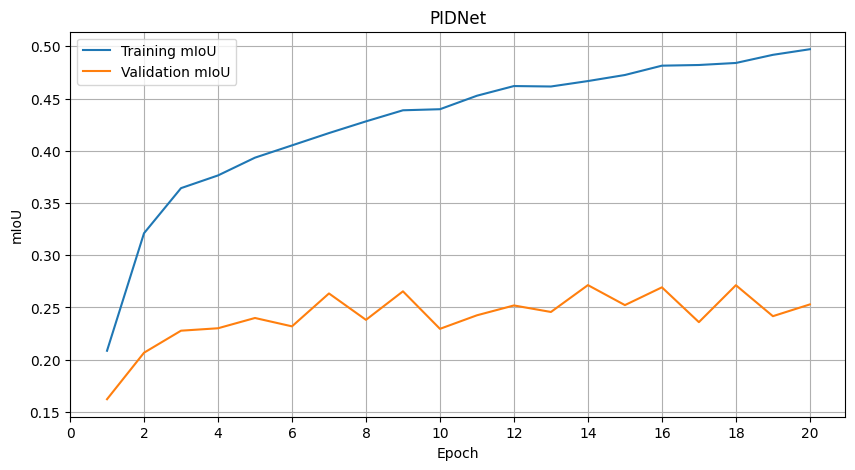

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_train_miou, label='Training mIoU')
plt.plot(range(1, num_epochs + 1), epoch_val_miou, label='Validation mIoU')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('PIDNet')
plt.legend()
plt.grid(True)
plt.xticks(range(0, num_epochs + 2, 2))
plt.show()


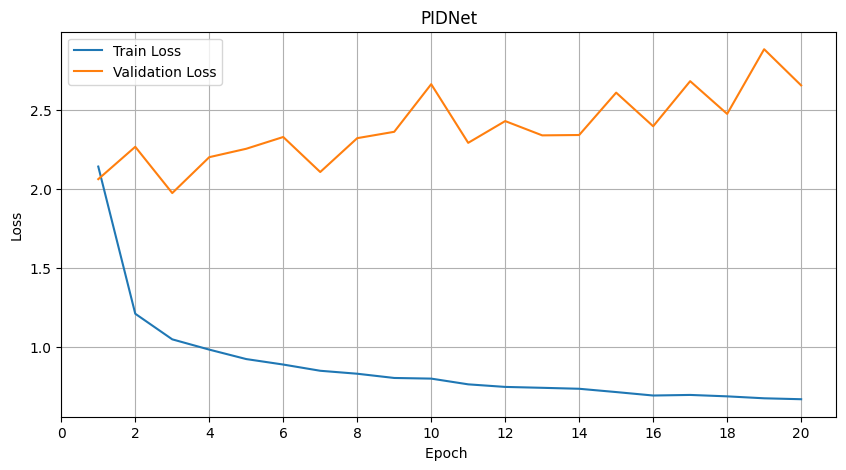

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), epoch_val_loss, label="Validation Loss")
plt.xlabel("Epoch ")
plt.ylabel("Loss")
plt.title("PIDNet")
plt.legend()
plt.grid(True)
plt.xticks(range(0, num_epochs + 2, 2))
plt.show()

In [ ]:
# Download the Test Image
!mkdir -p LoveDA/Test/Rural

!wget https://github.com/aliabbasi2000/Real-time-Domain-Adaptation-in-Semantic-Segmentation/blob/280a73361b252434aa65f9602b4b51714d092015/data/LoveDA/Test/Rural/4196.png -O LoveDA/Test/Rural/4196.png


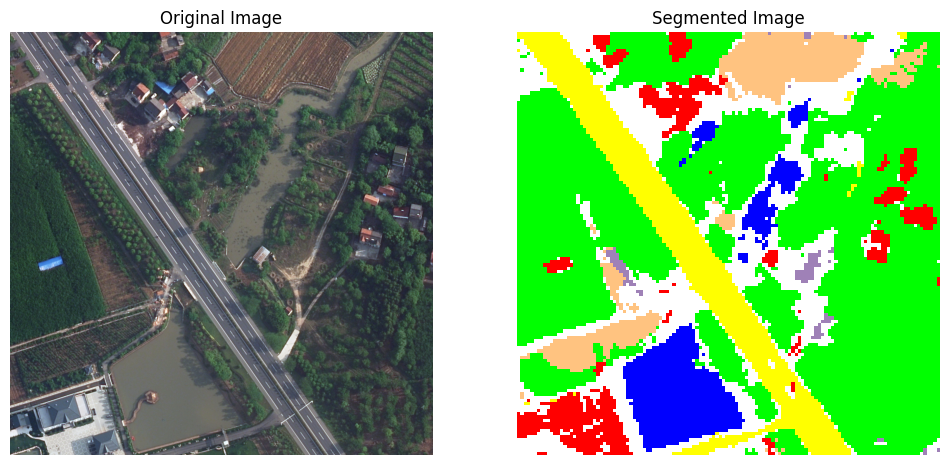

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Define label colors (R, G, B) for each class
class_labels = ["background", "building", "road", "water", "barren", "forest", "agriculture"]
label_colors = {
    "background": (255, 255, 255),        # White
    "building": (255, 0, 0),             # Red
    "road": (255, 255, 0),               # Yellow
    "water": (0, 0, 255),                # Blue
    "barren": (159, 129, 183),           # Purple
    "forest": (0, 255, 0),               # Green
    "agriculture": (255, 195, 128)       # Peach
}

# Load a single image for segmentation
image_path = "/content/PIDNet/LoveDA/Test/Rural"
image_files = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f)) and not f.startswith('.')]
image_name = image_files[0]
image = Image.open(os.path.join(image_path, image_name)).convert('RGB')



# Preprocess the image (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_image = transform(image).unsqueeze(0).to(device)

# Perform inference with the model
model.eval()
with torch.no_grad():
    output = model(input_image)  # Shape: (1, num_classes, H, W)
    output = output[0]  # Remove auxiliary outputs if present
    preds = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Shape: (H, W)

# Create a segmentation map
segmentation_map = np.zeros((preds.shape[0], preds.shape[1], 3), dtype=np.uint8)

for label_index, label_name in enumerate(class_labels):
    color = label_colors[label_name]
    segmentation_map[preds == label_index] = color

# Visualize the original image and segmentation map
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmentation_map)
plt.title("Segmented Image")
plt.axis("off")

plt.show()


#Here are the results of 7 different augmentation. Augmentation no. 4 gives us the best practice with Imou of 0.27

#Augmantation7: all Augs except GaussianBlur

Validation Loss: 1.9452, Validation mIoU: 0.2675

Class-wise IoU:
  background: 0.4959
  building: 0.3543
  road: 0.2131
  water: 0.2966
  barren: 0.0914
  forest: 0.1627
  agriculture: 0.2583

#Augmentation6: Only RandomRotate90

Validation Loss: 1.8232, Validation mIoU: 0.2637

Class-wise IoU:
  background: 0.4943
  building: 0.3063
  road: 0.2164
  water: 0.3013
  barren: 0.1157
  forest: 0.1566
  agriculture: 0.2550

#Augmentation5: Only GaussianBlur

Validation Loss: 1.9924, Validation mIoU: 0.2472

Class-wise IoU:
  background: 0.5000
  building: 0.3200
  road: 0.2273
  water: 0.3239
  barren: 0.0900
  forest: 0.0731
  agriculture: 0.1965

#Augmentation4: All Augs (The best Practice)
Details of Augmentation:

OneOf([HorizontalFlip(p=0.5), VerticalFlip(p=0.5), RandomRotate90(p=0.5), GaussianBlur(blur_limit=(3, 7), p=0.5),RandomBrightnessContras(brightness_limit=0.2, contrast_limit=0.2, p=0.5),MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.5),NoOp()], p=0.75),

Validation Loss: 1.9382, Validation mIoU: 0.2736

Class-wise IoU:
  background: 0.5085
  building: 0.3271
  road: 0.2415
  water: 0.2559
  barren: 0.0853
  forest: 0.1348
  agriculture: 0.3621

# Augmentation3: RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.5),

Validation Loss: 1.9632, Validation mIoU: 0.2383

Class-wise IoU:
  background: 0.4722
  building: 0.3635
  road: 0.1996
  water: 0.2604
  barren: 0.0809
  forest: 0.0923
  agriculture: 0.1994

# Augmentation2: OneOf([HorizontalFlip(p=0.5), VerticalFlip(p=0.5), RandomRotate90(p=0.5),GaussianBlur(blur_limit=(3, 7), p=0.5), NoOp()], p=0.75),

Validation Loss: 1.7113, Validation mIoU: 0.2669

Class-wise IoU:
  background: 0.4945
  building: 0.3915
  road: 0.2166
  water: 0.3269
  barren: 0.0921
  forest: 0.0876
  agriculture: 0.2590

# Augmentation1: Only RandomRotate90(p=0.5), GaussianBlur(blur_limit=(3, 7), p=0.5),

Validation Loss: 1.8494, Validation mIoU: 0.2513
Class-wise IoU:
  background: 0.4961
  building: 0.3070
  road: 0.2063
  water: 0.3012
  barren: 0.0636
  forest: 0.1090
  agriculture: 0.2762